In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
import pandas as pd

## Functions

In [12]:
# funciones


#ecuaciones diferenciales
def df1(y,t,params):   
    S,ZC,ZH,IC,IHC,IHH,MC, MH = y
    Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho,delta,delta_I,epsilon = params
    
    dS = Lambda*(S+ZC+ZH+IC+IHC+IHH) + gamma*ZC + gamma*ZH - rho*epsilon*(beta_C*S*ZC) - rho*delta*epsilon*(beta_H*S*ZH) - phi*S
    
    dZC = rho*epsilon*(beta_C*S*ZC) + omega_C*IC + alpha*ZH - xi_C*(1-gamma)*(1-delta)*ZC - delta*ZC - gamma*ZC - phi*ZC
    
    dZH = rho*delta*epsilon*(beta_H*S*ZH) + delta*ZC + omega_H*(IHH+IHC) - xi_H*(1-alpha)*ZH - alpha*ZH - phi*ZH - gamma*ZH
    
    dIC = xi_C*(1-gamma)*(1-delta)*ZC - delta_I*IC - omega_C*IC - (1-omega_C)*(1-delta_I)*eta*V_C*IC - phi*IC
    
    dIHC = delta_I*IC-omega_H*IHC-(1-omega_H)*eta*V_H*IHC-phi*IHC
    
    dIHH = xi_H*(1-alpha)*ZH-omega_H*IHH-(1-omega_H)*eta*V_H*IHH-phi*IHH
    
    dRC = (1-omega_C)*(1-delta_I)*eta*V_C*IC
    
    dRH = (1-omega_H)*eta*V_H*(IHC+IHH)

    derivs = [dS,dZC,dZH,dIC,dIHC,dIHH,dRC,dRH]
        
    return derivs


# Parameters and Initial Conditios

In [13]:
#parameters

Lambda= 0.000032
phi= 0.000019
xi_C= 0.00011
xi_H= 0.011
V_C= 0.368
V_H= 0.368/1.31
alpha = 0.32
gamma= 0.033
beta_H = 0.0005308
beta_C = beta_H*0.25
omega_H= 0.2
omega_C= 0.25*0.2
eta= 0.1
rho= np.array([1,1.27])
delta= 0.000054
delta_I= 0.8
epsilon= 0.01253

#Initial Conditions

N = 46000

S_0 = 0.5*N

Hospitalized = 0.0025*N 
Infected_Hospital = Hospitalized*0.0842


ZH_0 = Hospitalized*(1-0.0842)

IC_0 = Hospitalized*0.0842*0.5 #assume that infected in community are half of infected in hospital

IHC_0 = Infected_Hospital*0.87
IHH_0 = Infected_Hospital*0.13

ZC_0 = N-S_0-ZH_0-IC_0-IHC_0-IHH_0

RC_0 = 0
RH_0 = 0

y0 = [S_0,ZC_0,ZH_0,IC_0,IHC_0,IHH_0,RC_0,RH_0]
compartment_names = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$R_C$',r'$R_H$',r'$I_H$','N']

colors = {r'$S$':'goldenrod',
          r'$Z_C$':'blue',r'$Z_H$':'green',
          r'$I_C$':'red',r'$I_{HC}$':'purple',r'$I_{HH}$':'brown',
          r'$R_C$':'black',r'$R_H$':'chocolate',
          r'$I_H$':'orange','N':'darkblue'}

#timeline

tInc = 1
tStop = 700
t = np.arange(0,tStop,tInc)

# I) New parameters for antibiotic specific GN bacteria modelling

In [14]:
##Parameters

#betas

beta_H_quin = 0.00006171
beta_H_ceph = 0.006831
beta_H_carb = 0.0001766

#rho

rho_quin = 1.57
rho_ceph = 1.30
rho_carb = 1.01

parameters_bas1 = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H_quin,beta_C,omega_H,omega_C,eta,rho[0],delta,delta_I,epsilon
parameters_bas2 = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H_quin,beta_C,omega_H,omega_C,eta,rho[1],delta,delta_I,epsilon
parameters_quin = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H_quin,beta_C,omega_H,omega_C,eta,rho_quin,delta,delta_I,epsilon
parameters_ceph = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H_ceph,beta_C,omega_H,omega_C,eta,rho_ceph,delta,delta_I,epsilon
parameters_carb = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H_carb,beta_C,omega_H,omega_C,eta,rho_carb,delta,delta_I,epsilon

#Initial Conditions

def Initial_Conditions(p_ZC,p_ZH):
    N = 46000
    
    Hospitalized = 0.0025*N 
    Infected_Hospital = Hospitalized*0.0842
    
    #community
    ZC = p_ZC*N
    IC = Infected_Hospital*0.5 #assume that infected in community are half of infected in hospital
    RC = 0
    
    #hospitalized
    
    ZH = p_ZH*Hospitalized
    IHC = Infected_Hospital*0.87
    IHH = Infected_Hospital*0.13
    RH = 0
    
    
    #susceptibles
    
    S = N-ZC-IC-ZH-Infected_Hospital
    
    
    return [S,ZC,ZH,IC,IHC,IHH,RC,RH]

##quinolones

p_ZC_quin = 0.3949
p_ZH_quin = 0.4645

y0_quin = Initial_Conditions(p_ZC_quin,p_ZH_quin)

#cephalosporins

p_ZC_ceph = 0.2885
p_ZH_ceph = 0.4116

y0_ceph = Initial_Conditions(p_ZC_ceph,p_ZH_ceph)

#carbapenems

p_ZC_carb = 0.056
p_ZH_carb = 0.031

y0_carb = Initial_Conditions(p_ZC_carb,p_ZH_carb)

In [15]:
#Run the model

def model(Inicial_Conditions,parameters):
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    N = psoln[:,0]+psoln[:,1]+psoln[:,2]+psoln[:,3]+psoln[:,4]+psoln[:,5] #calculamos N
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    solutions = np.append(solutions,np.atleast_2d(N).T, axis=1)
    
    return solutions

RESULTS_bas1 = model(y0,parameters_bas1)
RESULTS_bas2 = model(y0,parameters_bas2)
RESULTS_quin = model(y0_quin,parameters_quin)
RESULTS_ceph = model(y0_ceph,parameters_ceph)
RESULTS_carb = model(y0_carb,parameters_carb)

In [42]:
#hacemos una tabla/dict con la comparación en porcentaje

def comparative(BASELINE,RESULTS):
    
    output = np.array([])
    
    for i, compartment in enumerate(compartment_names):
        
        mean_baseline_i = np.mean(BASELINE[-100:,i])
        mean_result_i = np.mean(RESULTS[-100:,i])
        
        comp_i = (mean_result_i-mean_baseline_i)/mean_baseline_i
        
        output = np.append(output,comp_i)
    
    return output


antibiotics_name = ['quin','ceph','carb']
compartments_name = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$R_C$',r'$R_H$',r'$I_H$','N']

#diccionario con baseline 1 (rho=1.0)

COMP1_quin = comparative(RESULTS_bas1,RESULTS_quin)
COMP1_ceph = comparative(RESULTS_bas1,RESULTS_ceph)
COMP1_carb = comparative(RESULTS_bas1,RESULTS_carb)

dict_COMP1 = {}

for i, name_comp in enumerate(compartments_name): #run through the compartments
    
    compartment = []
    
    for j,name_ant in enumerate(antibiotics_name):
        
        compartment.append(eval('COMP1_'+name_ant)[i])
        
    dict_COMP1[name_comp] = compartment

#diccionario con baseline 2 (rho=1.27)  

COMP2_quin = comparative(RESULTS_bas2,RESULTS_quin)
COMP2_ceph = comparative(RESULTS_bas2,RESULTS_ceph)
COMP2_carb = comparative(RESULTS_bas2,RESULTS_carb)

dict_COMP2 = {}

for i, name_comp in enumerate(compartments_name): #run through the compartments
    
    compartment = []
    
    for j,name_ant in enumerate(antibiotics_name):
        
        compartment.append(eval('COMP2_'+name_ant)[i])
        
    dict_COMP2[name_comp] = compartment

<ipython-input-50-513349786454>:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


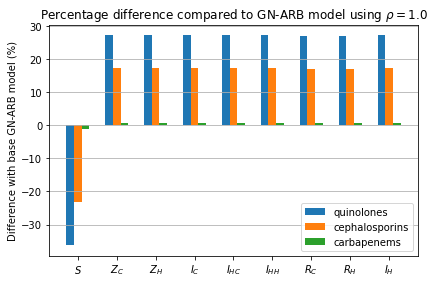

In [50]:
#plot rho=1

labels = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$R_C$',r'$R_H$',r'$I_H$']
quinolones = [100*dict_COMP1[key][0] for key in labels]
cephalosporines = [100*dict_COMP1[key][1] for key in labels]
carbapenems = [100*dict_COMP1[key][2] for key in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, quinolones, width, label='quinolones')
rects2 = ax.bar(x, cephalosporines, width, label='cephalosporins')
rects3 = ax.bar(x + width, carbapenems, width, label='carbapenems')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difference with base GN-ARB model (%)')
ax.set_title(r'Percentage difference compared to GN-ARB model using $\rho = 1.0$')
ax.set_xticks(x, labels)
ax.legend()
ax.yaxis.grid(True)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.xticks(x, labels)
plt.savefig("Diff_atbp1.pdf", dpi=280)

<ipython-input-51-4704482b95a6>:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


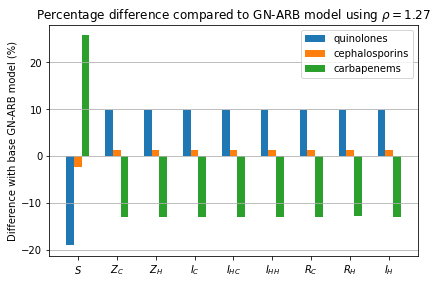

In [51]:
#plot rho=1.27

labels = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$R_C$',r'$R_H$',r'$I_H$']
quinolones = [100*dict_COMP2[key][0] for key in labels]
cephalosporines = [100*dict_COMP2[key][1] for key in labels]
carbapenems = [100*dict_COMP2[key][2] for key in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, quinolones, width, label='quinolones')
rects2 = ax.bar(x, cephalosporines, width, label='cephalosporins')
rects3 = ax.bar(x + width, carbapenems, width, label='carbapenems')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difference with base GN-ARB model (%)')
ax.set_title(r'Percentage difference compared to GN-ARB model using $\rho = 1.27$')
ax.set_xticks(x, labels)
ax.legend()
ax.yaxis.grid(True)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.xticks(x, labels)
plt.savefig("Diff_atbp127.pdf", dpi=250)

# II) New analyses by varying the transmission parameter and according to different GN bacterial species

In [45]:
#Range 

#Enterobacteriaceae
beta_H_ent_min = 0.000018 
beta_H_ent_max = 0.0048

beta_H_ent = [beta_H_ent_min,beta_H_ent_max]

#Klebsiella pneumoniae
beta_H_kleb_min = 0.0038 
beta_H_kleb_max = 0.0096 

beta_H_kleb = [beta_H_kleb_min,beta_H_kleb_max]

#Acinetobacter baumanii 
beta_H_aci_min = 0.0050 
beta_H_aci_max = 0.078 

beta_H_aci = [beta_H_aci_min,beta_H_aci_max]




In [46]:
# simulación min y max

def Simulaciones_beta (y0,parameters,list_beta_H):
    
    compartment_names = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$R_C$',r'$R_H$',r'$I_H$','N']
    Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho,delta,delta_I,epsilon = parameters
    
    RESULTS = {'min': None,
               'max': None,
               'mean':None}
    
    for i, beta_H in enumerate(list_beta_H):
        parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho,delta,delta_I,epsilon
        matrix = model(y0,parameters)
        
        if i==0:
            RESULTS['min'] = matrix
            
        else:
            RESULTS['max'] = matrix
    
    RESULTS['mean'] =  (RESULTS['min']+RESULTS['max'])/2
    
    return RESULTS

RESULTS1_ent = Simulaciones_beta(y0,parameters_bas1,beta_H_ent)
RESULTS1_kleb = Simulaciones_beta(y0,parameters_bas1,beta_H_kleb)
RESULTS1_aci  = Simulaciones_beta(y0,parameters_bas1,beta_H_aci)

RESULTS2_ent = Simulaciones_beta(y0,parameters_bas2,beta_H_ent)
RESULTS2_kleb = Simulaciones_beta(y0,parameters_bas2,beta_H_kleb)
RESULTS2_aci  = Simulaciones_beta(y0,parameters_bas2,beta_H_aci)

In [47]:
#Comp, baseline

bacterial_name = ['ent','kleb','aci']
compartments_name = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$R_C$',r'$R_H$',r'$I_H$','N']


COMP1_ent = {key: comparative(RESULTS_bas1,RESULTS1_ent[key]) for key in RESULTS1_ent.keys()}
COMP1_kleb = {key: comparative(RESULTS_bas1,RESULTS1_kleb[key]) for key in RESULTS1_kleb.keys()}
COMP1_aci = {key: comparative(RESULTS_bas1,RESULTS1_aci[key]) for key in RESULTS1_aci.keys()}


COMP2_ent = {key: comparative(RESULTS_bas2,RESULTS2_ent[key]) for key in RESULTS2_ent.keys()}
COMP2_kleb = {key: comparative(RESULTS_bas2,RESULTS2_kleb[key]) for key in RESULTS2_kleb.keys()}
COMP2_aci = {key: comparative(RESULTS_bas2,RESULTS2_aci[key]) for key in RESULTS2_aci.keys()}

<ipython-input-48-8a8789f186a3>:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


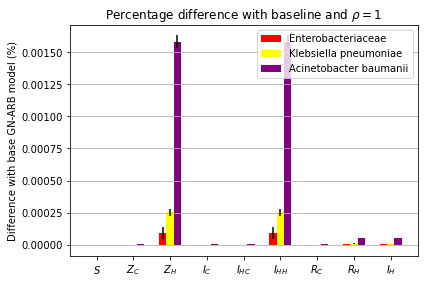

In [48]:
# plot 1

labels = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$R_C$',r'$R_H$',r'$I_H$']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()

error1 = (COMP1_ent['mean'][:-1]-COMP1_ent['min'][:-1])/1.96
error2 = (COMP1_ent['mean'][:-1]-COMP1_kleb['min'][:-1])/1.96
error3 = (COMP1_ent['mean'][:-1]-COMP1_aci['min'][:-1])/1.96

rects1 = ax.bar(x - width, COMP1_ent['mean'][:-1], width, yerr= error1, color = 'red', label='Enterobacteriaceae')
rects2 = ax.bar(x, COMP1_kleb['mean'][:-1], width,yerr= error2, color = 'yellow',label='Klebsiella pneumoniae')
rects3 = ax.bar(x + width, COMP1_aci['mean'][:-1], width,yerr= error3,color = 'purple', label='Acinetobacter baumanii')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difference with base GN-ARB model (%)')
ax.set_title(r'Percentage difference with baseline and $\rho = 1$')
ax.set_xticks(x, labels)
ax.legend()
ax.yaxis.grid(True)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

#plt.show()
plt.xticks(x, labels)
plt.savefig("Diff_bact1.pdf", dpi=250)

<ipython-input-49-58f875bf3325>:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


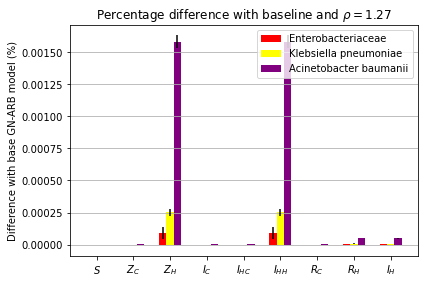

In [49]:
# plot 2

labels = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$R_C$',r'$R_H$',r'$I_H$']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()

error1 = (COMP2_ent['mean'][:-1]-COMP2_ent['min'][:-1])/1.96
error2 = (COMP2_ent['mean'][:-1]-COMP2_kleb['min'][:-1])/1.96
error3 = (COMP2_ent['mean'][:-1]-COMP2_aci['min'][:-1])/1.96

rects1 = ax.bar(x - width, COMP2_ent['mean'][:-1], width, yerr= error1, color = 'red', label='Enterobacteriaceae')
rects2 = ax.bar(x, COMP2_kleb['mean'][:-1], width,yerr= error2, color = 'yellow', label='Klebsiella pneumoniae')
rects3 = ax.bar(x + width, COMP2_aci['mean'][:-1], width,yerr= error3, color = 'purple',label='Acinetobacter baumanii')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difference with base GN-ARB model (%)')
ax.set_title(r'Percentage difference with baseline and $\rho = 1.27$')
ax.set_xticks(x, labels)
ax.legend()
ax.yaxis.grid(True)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.xticks(x, labels)
plt.savefig("Diff_bact127.pdf", dpi=250)